### Train CIFAR classifier using ResNet from scratch

In [1]:
import torch
import torchvision
import lightning
from lightning.pytorch.loggers import CSVLogger
from torchvision import datasets, transforms
from torch.utils.data import dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common_def import LightningModel, plot_metrics_from_csv_log
import torch.nn.functional as F

/var/folders/jv/rdf06dcs2hg0140vr6yl1lgw0000gn/T/ipykernel_29616/3323347595.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Load the CIFAR-10 dataset

In [2]:
class CIFAR10DataModule(lightning.LightningDataModule):
    def __init__(self, data_dir='./dataset/cifar-10', batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def prepare_data(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.train_dataset = datasets.CIFAR10(root=self.data_dir, train=True, transform=transform, download=True)
        self.test_dataset = datasets.CIFAR10(root=self.data_dir, train=False, transform=transform, download=True)

    def setup(self, stage=None):
        self.train_dataset, self.val_dataset = dataset.random_split(dataset=self.train_dataset, lengths=[45000, 5000])

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False)
    

In [3]:
cifar_dm = CIFAR10DataModule()
cifar_dm.prepare_data()
cifar_dm.setup()

100%|██████████| 170498071/170498071 [00:38<00:00, 4451712.17it/s]


Extracting ./dataset/cifar-10/cifar-10-python.tar.gz to ./dataset/cifar-10
Files already downloaded and verified


#### Examine the dataset

Check dataset size

In [4]:
print(f'train size {len(cifar_dm.train_dataset)}')
print(f'val size {len(cifar_dm.val_dataset)}')
print(f'test size {len(cifar_dm.test_dataset)}')

for image, label in cifar_dm.train_dataset:
    print(image)
    print(label)
    break 

train size 45000
val size 5000
test size 10000
tensor([[[0.9529, 0.9216, 0.9216,  ..., 0.9216, 0.9216, 0.9294],
         [0.9451, 0.9137, 0.9216,  ..., 0.9216, 0.9216, 0.9216],
         [0.9608, 0.9294, 0.9294,  ..., 0.9373, 0.9373, 0.9373],
         ...,
         [0.7882, 0.7490, 0.7490,  ..., 0.7098, 0.7412, 0.7804],
         [0.7882, 0.7569, 0.7569,  ..., 0.7490, 0.7804, 0.7961],
         [0.7961, 0.7647, 0.7647,  ..., 0.7882, 0.8118, 0.8275]],

        [[0.9529, 0.9216, 0.9216,  ..., 0.9216, 0.9216, 0.9294],
         [0.9451, 0.9137, 0.9216,  ..., 0.9216, 0.9216, 0.9216],
         [0.9608, 0.9294, 0.9294,  ..., 0.9373, 0.9373, 0.9373],
         ...,
         [0.7961, 0.7569, 0.7490,  ..., 0.7412, 0.7647, 0.7961],
         [0.7961, 0.7647, 0.7647,  ..., 0.7725, 0.7882, 0.8118],
         [0.8118, 0.7804, 0.7804,  ..., 0.7961, 0.8039, 0.8196]],

        [[0.9686, 0.9373, 0.9373,  ..., 0.9373, 0.9373, 0.9451],
         [0.9608, 0.9294, 0.9373,  ..., 0.9373, 0.9373, 0.9373],
         [0

Visualize an example

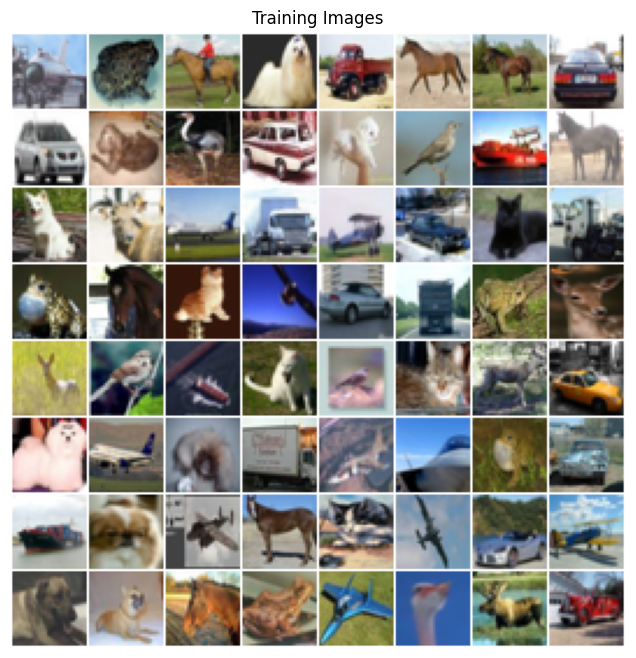

In [5]:
for images, labels in cifar_dm.train_dataloader():
    break 

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(
    np.transpose(torchvision.utils.make_grid(
        images,
        padding=1,
        pad_value=1.0,
        normalize=True
    ),
    (1, 2, 0)))

plt.show()

Labels
- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck

Check label distribution

In [6]:
from collections import Counter

train_counter = Counter()
for images, labels in cifar_dm.train_dataloader():
    train_counter.update(labels.tolist())
print(f'train labels distribution: {sorted(train_counter.items())}')

val_counter = Counter()
for images, labels in cifar_dm.val_dataloader():
    val_counter.update(labels.tolist())
print(f'val labels distribution: {sorted(val_counter.items())}')

test_counter = Counter()
for images, labels in cifar_dm.test_dataloader():
    test_counter.update(labels.tolist())
print(f'test labels distribution: {sorted(test_counter.items())}')

train labels distribution: [(0, 4516), (1, 4541), (2, 4483), (3, 4491), (4, 4497), (5, 4490), (6, 4490), (7, 4462), (8, 4514), (9, 4516)]
val labels distribution: [(0, 484), (1, 459), (2, 517), (3, 509), (4, 503), (5, 510), (6, 510), (7, 538), (8, 486), (9, 484)]
test labels distribution: [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


#### Zero-rule classifier

In [7]:
zerorule_acc = train_counter.most_common(1)[0][1] / sum(train_counter.values())
print(f'zero-rule accuracy: {zerorule_acc*100:.2f}%')

zero-rule accuracy: 10.09%


#### Define ResNet model

In [6]:
class BasicBlock(torch.torch.nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [9]:
class PyTorchResNet18(torch.nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        super().__init__()
        
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        self.inplanes = 64
        self.conv1 = torch.nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [7]:

def make_pytorch_resnet18(num_classes, grayscale=False):
    """Constructs a ResNet-18 model."""
    model = PyTorchResNet18(block=BasicBlock, 
                            layers=[2, 2, 2, 2],
                            num_classes=num_classes,
                            grayscale=grayscale)
    return model

#### Training

In [10]:
lightning.seed_everything(123)

cifar_dm = CIFAR10DataModule()

torch_model = make_pytorch_resnet18(num_classes=10)
lightning_model = LightningModel(torch_model=torch_model, num_classes=10, learning_rate=0.1)

trainer = lightning.Trainer(
    max_epochs=10, 
    logger=CSVLogger('lightning_logs', name='ResNet18-CIFAR10'), 
    deterministic=True,
    accelerator='gpu', # cannot train on CPU
    devices=1
    )

trainer.fit(lightning_model, cifar_dm)

Seed set to 123
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name        | Type               | Params
---------------------------------------------------
0 | torch_model | PyTorchResNet18    | 11.2 M
1 | train_acc   | MulticlassAccuracy | 0     
2 | val_acc     | MulticlassAccuracy | 0     
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 3